In [30]:
import os,sys,glob

import numpy as np
import astropy.units as u
import matplotlib.pyplot as plt

from astropy.table import Table
import astropy.units as u

from gammapy.datasets import FluxPointsDataset
from gammapy.estimators import FluxPoints

In [4]:
def ssdc_sedbuilder_reader(file):
    #######################
    #### ARCHIVAL DATA ####
    #######################
    D = None
    
    with open(file) as fi:
        for l in fi.readlines():
            #print(l)
            if l=='\n':
                lcontinue=False
                continue
            elif 'id = ' in l:
                # New instrument
                inst,iid = l.split("# ")[-1].split(" (id = ")
                iid = int(iid.split(")")[0])
                continue
            elif '#' in l: 
                continue

            ### Normal data
            l = l.rstrip()
            if '; UPPER LIMIT' in l:
                uplim = 1
                l = l.replace(' ; UPPER LIMIT','')
            else:
                uplim = 0
            while '  ' in l:
                l = l.replace('  ',' ')

            l = [float(it) for it in l.split(" ")]
            ldata = np.asarray([l+[uplim,inst,iid]])
            
            # Build a data array or concatenate new data
            if D is None:
                D = ldata
            else:
                D = np.concatenate([D,ldata])
    
        # this should never happen
        if D is None:
            print(f'Error processing data from {srcname}')
            print(f'---------- File contents -------------')
            print(open(file).read())
            print(f'--------------- End ------------------')
    
        #filt = np.asarray([True if 'Fermi' not in D[k][7] else False for k,l in enumerate(D)])
        filt = ~((np.asarray(D[:,0],dtype=float)>27)*(np.asarray(D[:,0],dtype=float)<27))        
        
        D = {
            'logE':     np.asarray(D[:,0][filt],dtype=float),
            'logE_err': np.asarray(D[:,1][filt],dtype=float),
            'logF':     np.asarray(D[:,2][filt],dtype=float),
            'logF_err': np.asarray(D[:,3][filt],dtype=float),
            'tstart':   np.asarray(D[:,4][filt],dtype=float),
            'tstop':    np.asarray(D[:,5][filt],dtype=float),
            'UL':       np.asarray(D[:,6][filt],dtype=int),
            'instrum':  np.asarray(D[:,7][filt]),
            'data':     np.asarray(['SSDC' for l in D])[filt],
            'id':       np.asarray(D[:,8][filt],dtype=int),
        }
        
        return(D)

In [5]:
ssdc_archive = ssdc_sedbuilder_reader("/home/mnievas/Projects/OP313_flare_Dec_2023/sed1310p3220.txt")

In [19]:
ssdc_archive.keys()

dict_keys(['logE', 'logE_err', 'logF', 'logF_err', 'tstart', 'tstop', 'UL', 'instrum', 'data', 'id'])

In [21]:
ssdc_archive

{'logE': array([26.383456, 24.161967, 25.161967, 23.161967, 23.684845, 22.684845,
        23.383815, 23.383815, 23.383815, 23.383815, 23.383815, 23.383815,
        23.383815, 23.383815, 23.383815, 23.383815, 23.383815, 23.383815,
        23.383815, 23.383815, 23.383815, 23.383815, 23.383815, 23.383815,
        23.383815, 23.383815, 23.383815, 24.161967, 25.161967, 23.161967,
        23.684845, 22.684845, 24.161967, 25.161967, 23.161967, 23.684845,
        22.684845, 25.121888, 25.121888, 24.121888, 24.121888, 25.883434,
        25.883434, 24.622007, 24.622007, 23.622007, 23.622007, 23.12156 ,
        23.12156 , 22.622007, 22.622007, 22.232742, 22.232742, 18.249687,
        17.860578, 17.533899, 17.232996, 17.184407, 17.573568, 17.573568,
        17.383815, 17.383815, 17.383815, 17.383815, 17.383815, 17.383815,
        17.383815, 17.383815, 16.883434, 16.883434, 16.883434, 16.883434,
        16.883434, 16.883434, 16.883434, 16.883434, 16.883434, 16.883434,
        16.883434, 18.033826, 

In [18]:
argsort = np.argsort(ssdc_archive['logE'])

In [38]:
table = Table(names=['e_ref','e2dnde', 'e2dnde_err', 'e2dnde_errn', 'e2dnde_errp', 'e2dnde_ul', 'is_ul'])
hz_to_ev = 4.1356655385381E-15 #* 1e-6
for k in argsort:
    e_ref  = 10**ssdc_archive['logE'][k]*hz_to_ev*u.eV
    e2dnde = 10**ssdc_archive['logF'][k]*u.Unit('erg cm-2 s-1')
    e2dnde_errp = -10**(ssdc_archive['logF'][k])+10**(ssdc_archive['logF'][k]+ssdc_archive['logF_err'][k])
    e2dnde_errp = e2dnde_errp*u.Unit('erg cm-2 s-1')
    e2dnde_errn = +10**(ssdc_archive['logF'][k])-10**(ssdc_archive['logF'][k]-ssdc_archive['logF_err'][k])
    e2dnde_errn = e2dnde_errn*u.Unit('erg cm-2 s-1')
    e2dnde_err = e2dnde_errp
    is_ul = bool(ssdc_archive['UL'][k])
    if is_ul:
        e2dnde_ul = e2dnde
    else:
        e2dnde_ul = e2dnde*0

    table.add_row([e_ref,e2dnde,e2dnde_err,e2dnde_errn,e2dnde_errp,e2dnde_ul,is_ul])
table.meta['SED_TYPE'] = "e2dnde"

In [40]:
table.write("../../ArchivalData/archival_data.ecsv",format='ascii.ecsv',overwrite=True)

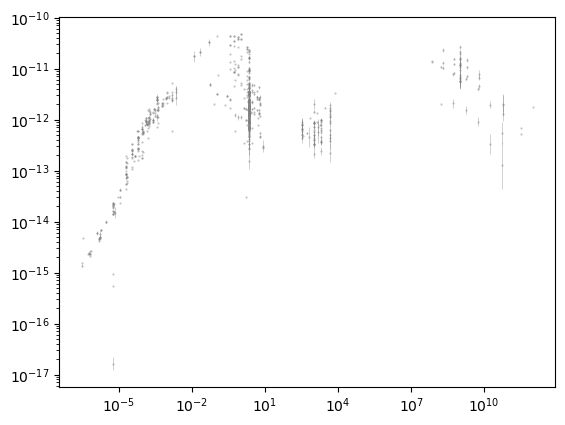

In [41]:
plt.errorbar(
    x = table['e_ref'],
    y = table['e2dnde'],
    yerr = [table['e2dnde_errn'],table['e2dnde_errp']],
    color='gray',
    ms=1,
    alpha=0.5,
    marker='.',
    lw=0.5,
    #capsize=0.5,
    ls='None',
    label='SSDC / archive',
    zorder=-10
)
plt.xscale('log')
plt.yscale('log')